# Overview
Membuat Visualisasi BFS ,DFS

## Visualization Tools

In [1]:
!conda install -y graphviz pygraphviz

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - graphviz
    - pygraphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.12               |           py36_0         3.0 MB
    graphviz-2.40.1            |       h21bd128_2         6.5 MB
    openssl-1.0.2t             |       h7b6447c_1         2.2 MB
    pygraphviz-1.3             |   py36h14c3975_1         111 KB
    ------------------------------------------------------------
                                           Total:        11.8 MB

The following NEW packages will be INSTALLED:

  graphviz          

In [2]:
!pip install -qq celluloid

In [7]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display, SVG, clear_output
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

## Utility Functions

In [8]:
import inspect
import doctest
import copy
import functools
def autotest(func):
    globs = copy.copy(globals())
    globs.update({func.__name__: func})
    doctest.run_docstring_examples(
        func, globs, verbose=True, name=func.__name__)
    return func

@autotest
def retrieve_name(var, back_step=None):
    # type: (Any, Optional[int]) -> str
    """Gets the name of the parent variable (if exists).
    Params:
        back_step is the number of steps to go back (None or <0 triggers deepest possible)
    
    >>> f = lambda x, n: retrieve_name(x, n)
    >>> a = (None, '')
    >>> f(a, 0)
    'var'
    >>> f(a, 1)
    'x'
    >>> f(a, 2)
    'a'
    """
    
    if back_step is None:
        i = 1
        while len(retrieve_name(var, i))>0:
            i+=1
        return retrieve_name(var, i-1)
    
    c_frame = inspect.currentframe()
    for _ in range(back_step):
        c_frame = c_frame.f_back
    
    callers_local_vars = c_frame.f_locals.items()
    valid_list = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    if len(valid_list)>0:
        return valid_list[-1]
    else:
        return ''

Finding tests in retrieve_name
Trying:
    f = lambda x, n: retrieve_name(x, n)
Expecting nothing
ok
Trying:
    a = (None, '')
Expecting nothing
ok
Trying:
    f(a, 0)
Expecting:
    'var'
ok
Trying:
    f(a, 1)
Expecting:
    'x'
ok
Trying:
    f(a, 2)
Expecting:
    'a'
ok


## Basic Graph Class
Berikut ini adalah kelas graf dasar yang terdiri dari hanya sebuah node dan children. Kami menambahkan instrumen ke fungsi `.value` dan `.children` sehingga kami dapat melacak kapan mereka diakses.

In [9]:
from typing import List, Optional
from networkx.drawing.nx_agraph import to_agraph 
class GraphNode:
    _cur_graph = None
    def __init__(self, 
                 value, # type: Any
                 children=None, # type: Optional[List[GraphNode]]
                 siblings=None, # type: Optional[List[GraphNode]]
                 verbose=True
                ):
        if children is None:
            self._children = []
        elif isinstance(children, GraphNode):
            self._children = [children]
        else:
            self._children = children
        if siblings is None:
            self._siblings = []
        elif isinstance(siblings, GraphNode):
            self._siblings = [siblings]
        else:
            self._siblings = siblings
        self._value = value
        self.verbose = True
    
    def _record_read(self, name, desc):
        if self._cur_graph is not None:
            self._cur_graph.nodes[self._value]['color'] = 'red'
            old_label = self._cur_graph.nodes[self._value].get('label', self._value)
            new_label = f'*{name}={self._value}'
            if old_label!=self._value:
                new_label = '\n'.join(set([old_label, new_label]))
            self._cur_graph.nodes[self._value]['label'] = new_label
        if self.verbose:
            print(f'Read {desc} from {name}')
        
    @property
    def value(self):
        self._record_read(name=retrieve_name(self), desc='value')
        return self._value
    
    @property
    def children(self):
        self._record_read(name=retrieve_name(self), desc='children')
        return self._children
    
    def add_child(self, child):
        if not isinstance(child, GraphNode):
            child = GraphNode(child)
        self._children.append(child)
        return child
    
    def add_siblings(self, siblings):
        if isinstance(siblings, list):
            return [self.add_siblings(c_sibling) for c_sibling in siblings]
        if not isinstance(siblings, GraphNode):
            siblings = GraphNode(siblings)
        self._siblings.append(siblings)
        return siblings
    
    def create_graph(self):
        # type: (GraphNode) -> nx.Graph
        G = nx.MultiDiGraph()
        visisted_nodes = set()
        c_sibling_pairs = [(None, self)]+[(None, c_node) for c_node in self._siblings]
        while len(c_sibling_pairs)>0:
            c_parent_node, c_active_node = c_sibling_pairs.pop()
            if self.verbose:
                print(c_parent_node, c_active_node)
            if c_parent_node is not None:
                G.add_edge(c_parent_node._value, c_active_node._value)
            else:
                G.add_node(c_active_node._value)

            if (c_active_node not in visisted_nodes) or (c_parent_node is None):
                # only traverse children if we haven't been here before
                for c_child in c_active_node._children:
                    c_sibling_pairs.append((c_active_node, c_child))
                visisted_nodes.add(c_active_node)
        return G
    
    @property
    def graph(self):
        if GraphNode._cur_graph is None:
            GraphNode._cur_graph = self.create_graph()
        return GraphNode._cur_graph
    
    def clear(self):
        g = self.graph
        for k in g.nodes():
            g.nodes[k]['color'] = 'green'
            g.nodes[k]['label'] = k
        GraphNode._cur_graph = g
    
    def reset(self):
        GraphNode._cur_graph = None
        
    def __repr__(self):
        return f'GraphNode ({self._value}): {len(self._children)}'
    
    

In [10]:
def build_graph():
    head = GraphNode('head')
    body = head.add_child('body')
    for k in 'RL':
        body.add_child(f'arm_{k}').add_child(f'hand_{k}').add_child(f'finger_{k}')
        foot = body.add_child(f'leg_{k}').add_child(f'foot_{k}')
        foot.add_child(f'toe_{k}').add_child(head) # a few weird loops
    return head
a = build_graph()
    

## Graph Visualization Code
Kami membangun metode untuk memvisualisasikan grafik menggunakan `dot` dan `matplotlib`, kemudian kami menambahkannya ke fungsi utama.

In [15]:
_graph_count = 0
def draw_graph_dot(g):
    global _graph_count
    if isinstance(g, GraphNode):
        g = g.graph
    g.graph['edge'] = {'arrowsize': '1', 'splines': 'curved'}
    A = to_agraph(g) 
    A.layout('dot')  
    graph_name = '{:04d}.svg'.format(_graph_count)
    A.draw(graph_name)   
    _graph_count+=1
    return SVG(graph_name)
def draw_graph_mpl(g, pos = None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout):
    if isinstance(g, GraphNode):
        g = g.graph
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]-0.1]
    
    nx.draw_networkx_edges(g, pos,  ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75)
    nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax)
    ax.autoscale()
    return fig, ax, pos
GraphNode.draw = draw_graph_mpl
GraphNode.dot = draw_graph_dot

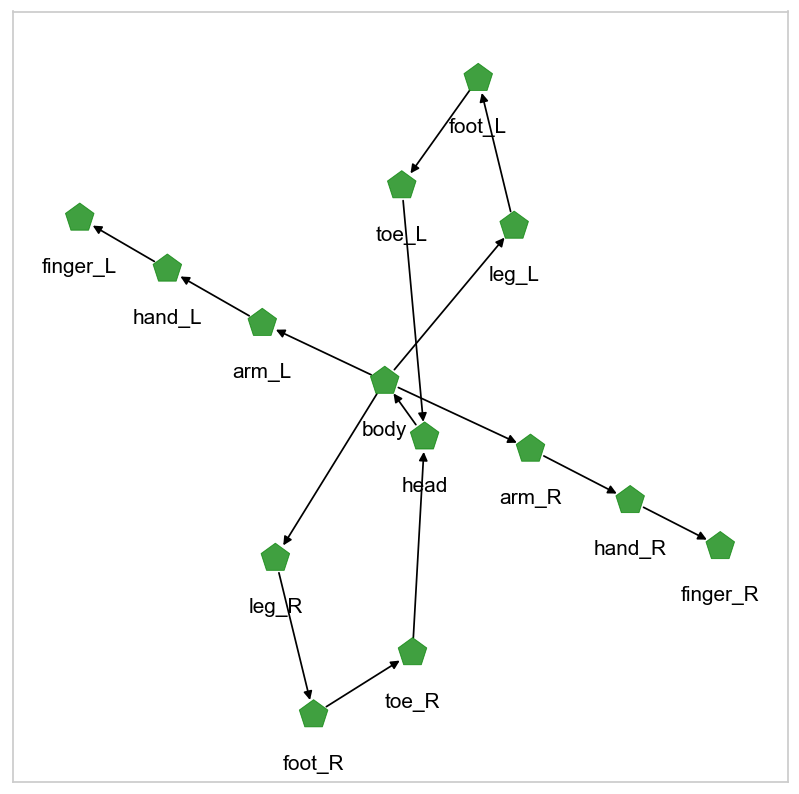

In [16]:
a.draw();

## Simple Reading Example
membaca beberapa node  dan valuenya lalu ditampilkan hasilnya


In [17]:
a.value
b = a.children[-1]
b.value

Read value from a
Read children from a
Read value from b


'body'

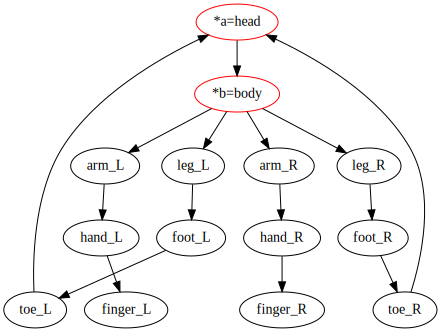

In [18]:
b.dot()

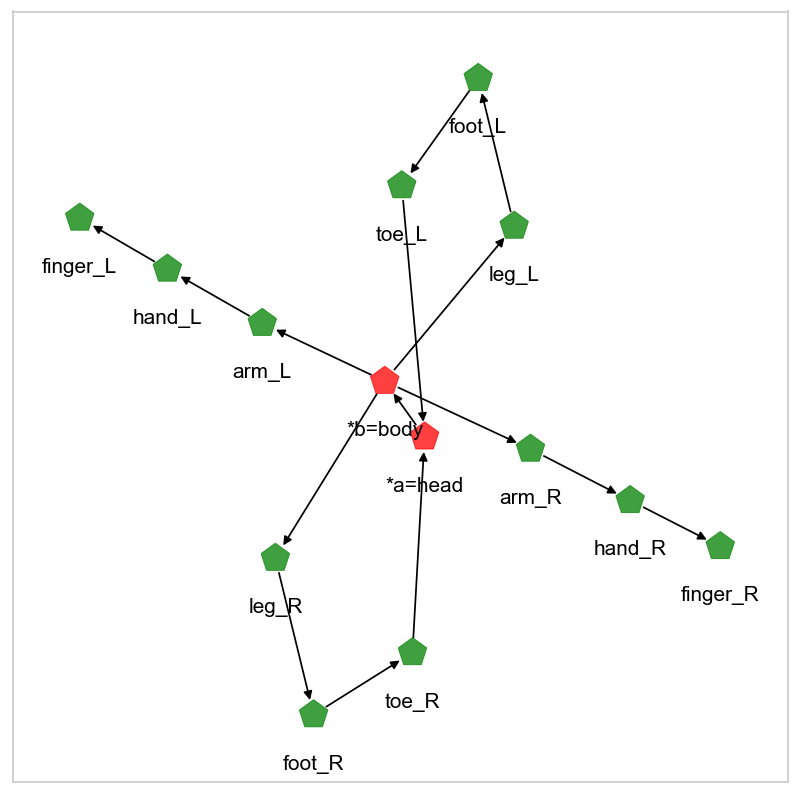

In [19]:
b.draw();

## Animation Code
membuat animasi untuk perjalan traversal graph

In [20]:
from celluloid import Camera
class Iterator:
    def __init__(self, in_gn, max_value=None, **kwargs):
        self._gn = in_gn
        self._fig, self._ax, self._pos = in_gn.draw(**kwargs)
        self._cam = Camera(self._fig)
        self.idx = 0
        self._max_value = max_value
        self.increment()
    
    def increment(self):
        #self._ax.clear()
        self._gn.draw(ax=self._ax, pos=self._pos)
        self._ax.set_title(f'Frame: {self.idx}')
        self._cam.snap()
        self._gn.clear()
        self.idx+=1
        if self._max_value is not None:
            if self.idx>=self._max_value:
                raise ValueError(f'Iteration count exceeded {self.idx}')
        return self.idx
    
    def __iadd__(self, value):
        for i in range(value):
            self.increment()
        return self
    
    def show(self, **kwargs):
        return self._cam.animate(**kwargs)
    
    def _repr_html_(self):
        return self._cam.animate(interval=750).to_jshtml()
    
    def as_gif(self, gif_name):
        self.show(interval=760, blit=True, repeat=True).save(gif_name)
        return Image(gif_name)

def get_animation_iter(in_gn, max_value=None, **kwargs):
    in_gn.reset()
    in_gn._iter = Iterator(in_gn, max_value=max_value, **kwargs)
    return in_gn._iter

GraphNode.get_iter = get_animation_iter

# Simple Depth First Search

None GraphNode (head): 1
GraphNode (head): 1 GraphNode (body): 4
GraphNode (body): 4 GraphNode (leg_L): 1
GraphNode (leg_L): 1 GraphNode (foot_L): 1
GraphNode (foot_L): 1 GraphNode (toe_L): 1
GraphNode (toe_L): 1 GraphNode (head): 1
GraphNode (body): 4 GraphNode (arm_L): 1
GraphNode (arm_L): 1 GraphNode (hand_L): 1
GraphNode (hand_L): 1 GraphNode (finger_L): 0
GraphNode (body): 4 GraphNode (leg_R): 1
GraphNode (leg_R): 1 GraphNode (foot_R): 1
GraphNode (foot_R): 1 GraphNode (toe_R): 1
GraphNode (toe_R): 1 GraphNode (head): 1
GraphNode (body): 4 GraphNode (arm_R): 1
GraphNode (arm_R): 1 GraphNode (hand_R): 1
GraphNode (hand_R): 1 GraphNode (finger_R): 0
Read children from c_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
Read children from i_node
R

ValueError: Iteration count exceeded 15

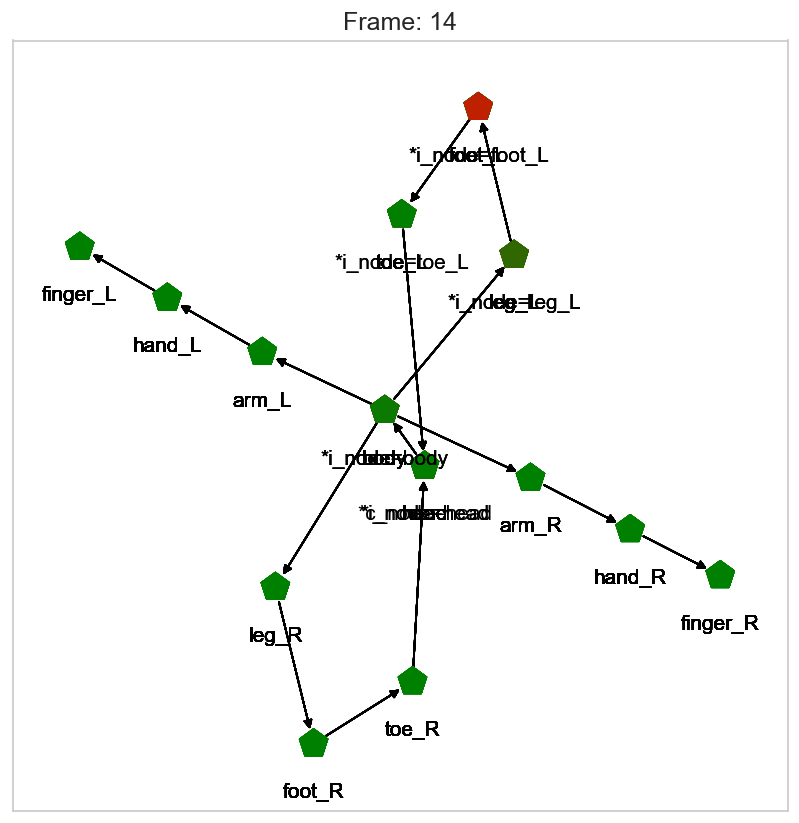

In [21]:
i = a.get_iter(max_value=15)
next_nodes = [a]
while len(next_nodes)>0:
    c_node = next_nodes.pop()
    for i_node in c_node.children:
        next_nodes.append(i_node)
    i+=1

In [26]:
a._iter.as_gif('dump_traverse.gif')
a._iter

MovieWriter stderr:
[gif @ 000001DE002E1480] GIF muxer supports only a single video GIF stream.
[out#0/gif @ 000001DE00298E40] Could not write header (incorrect codec parameters ?): Invalid argument
Error while filtering: Invalid argument
[out#0/gif @ 000001DE00298E40] Nothing was written into output file, because at least one of its streams received no packets.



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '1.3157894736842106', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'dump_traverse.gif']' returned non-zero exit status 4294967274.

# Binary Tree Search
Here we show 3 different ways of 'searching' a binary tree for a given key.

In [27]:
from networkx.drawing.nx_agraph import graphviz_layout
def _split_and_sub(in_node_list):
    if len(in_node_list)>2:
        mid_point = len(in_node_list)//2
        head = in_node_list.pop(mid_point)
        
        left_side = _split_and_sub(in_node_list[:mid_point])
        if left_side is not None:
            head.add_child(left_side)
            
        right_side = _split_and_sub(in_node_list[mid_point:])
        if right_side is not None:
            head.add_child(right_side)
        return head
    
    elif len(in_node_list)>0:
        head = in_node_list.pop(0)
        while len(in_node_list)>0:
            head.add_child(in_node_list.pop(0))
        return head
    else:
        raise ValueError('Empty node list')
def build_btree(max_index):
    all_nodes = [GraphNode(i) for i in range(max_index)]
    all_nodes[0].reset()
    return _split_and_sub(all_nodes)

None GraphNode (15): 2
GraphNode (15): 2 GraphNode (23): 2
GraphNode (23): 2 GraphNode (27): 2
GraphNode (27): 2 GraphNode (29): 2
GraphNode (29): 2 GraphNode (30): 0
GraphNode (29): 2 GraphNode (28): 0
GraphNode (27): 2 GraphNode (25): 2
GraphNode (25): 2 GraphNode (26): 0
GraphNode (25): 2 GraphNode (24): 0
GraphNode (23): 2 GraphNode (19): 2
GraphNode (19): 2 GraphNode (21): 2
GraphNode (21): 2 GraphNode (22): 0
GraphNode (21): 2 GraphNode (20): 0
GraphNode (19): 2 GraphNode (17): 2
GraphNode (17): 2 GraphNode (18): 0
GraphNode (17): 2 GraphNode (16): 0
GraphNode (15): 2 GraphNode (7): 2
GraphNode (7): 2 GraphNode (11): 2
GraphNode (11): 2 GraphNode (13): 2
GraphNode (13): 2 GraphNode (14): 0
GraphNode (13): 2 GraphNode (12): 0
GraphNode (11): 2 GraphNode (9): 2
GraphNode (9): 2 GraphNode (10): 0
GraphNode (9): 2 GraphNode (8): 0
GraphNode (7): 2 GraphNode (3): 2
GraphNode (3): 2 GraphNode (5): 2
GraphNode (5): 2 GraphNode (6): 0
GraphNode (5): 2 GraphNode (4): 0
GraphNode (3): 2 Gr

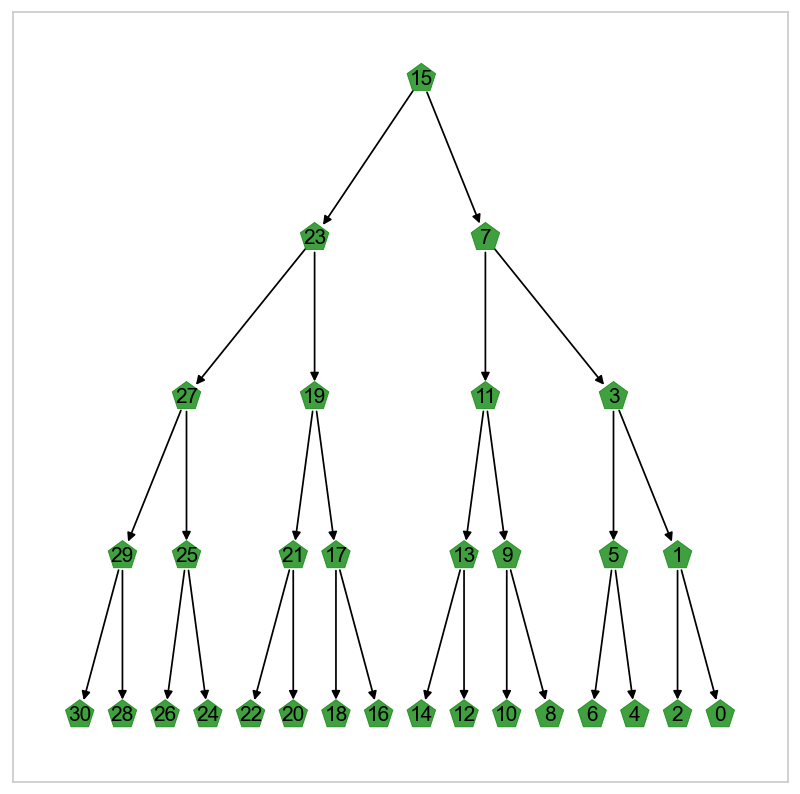

In [28]:
sample_btree = build_btree(31)
sample_btree.draw(pos=graphviz_layout(sample_btree.graph, prog='dot'));

## Depth First Search

In [29]:
def depth_first_search(head_node, idx):
    pos = graphviz_layout(head_node.graph, prog='dot')
    i = head_node.get_iter(max_value=32, pos=pos)
    next_nodes = [head_node]
    while len(next_nodes)>0:
        c_node = next_nodes.pop(-1)
        if c_node.value==idx:
            return c_node
        next_nodes += c_node.children
        i+=1
    return None

None GraphNode (15): 2
GraphNode (15): 2 GraphNode (23): 2
GraphNode (23): 2 GraphNode (27): 2
GraphNode (27): 2 GraphNode (29): 2
GraphNode (29): 2 GraphNode (30): 0
GraphNode (29): 2 GraphNode (28): 0
GraphNode (27): 2 GraphNode (25): 2
GraphNode (25): 2 GraphNode (26): 0
GraphNode (25): 2 GraphNode (24): 0
GraphNode (23): 2 GraphNode (19): 2
GraphNode (19): 2 GraphNode (21): 2
GraphNode (21): 2 GraphNode (22): 0
GraphNode (21): 2 GraphNode (20): 0
GraphNode (19): 2 GraphNode (17): 2
GraphNode (17): 2 GraphNode (18): 0
GraphNode (17): 2 GraphNode (16): 0
GraphNode (15): 2 GraphNode (7): 2
GraphNode (7): 2 GraphNode (11): 2
GraphNode (11): 2 GraphNode (13): 2
GraphNode (13): 2 GraphNode (14): 0
GraphNode (13): 2 GraphNode (12): 0
GraphNode (11): 2 GraphNode (9): 2
GraphNode (9): 2 GraphNode (10): 0
GraphNode (9): 2 GraphNode (8): 0
GraphNode (7): 2 GraphNode (3): 2
GraphNode (3): 2 GraphNode (5): 2
GraphNode (5): 2 GraphNode (6): 0
GraphNode (5): 2 GraphNode (4): 0
GraphNode (3): 2 Gr

GraphNode (4): 0

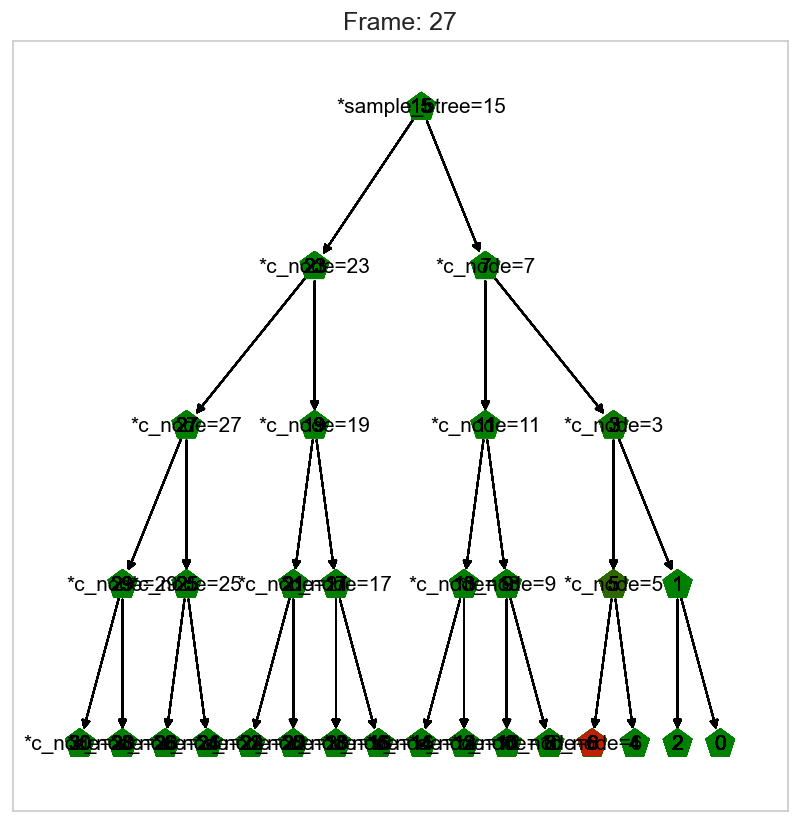

In [30]:
depth_first_search(head_node=sample_btree, idx=4)

In [31]:
sample_btree._iter.as_gif('dfs_search.gif')
sample_btree._iter

MovieWriter stderr:
[gif @ 000001DD49421340] GIF muxer supports only a single video GIF stream.
[out#0/gif @ 000001DD493DADC0] Could not write header (incorrect codec parameters ?): Invalid argument
Error while filtering: Invalid argument
[out#0/gif @ 000001DD493DADC0] Nothing was written into output file, because at least one of its streams received no packets.



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1000', '-pix_fmt', 'rgba', '-r', '1.3157894736842106', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'dfs_search.gif']' returned non-zero exit status 4294967274.

## Breadth First Search

In [32]:
def breadth_first_search(head_node, idx):
    pos = graphviz_layout(head_node.graph, prog='dot')
    i = head_node.get_iter(max_value=32, pos=pos)
    next_nodes = [head_node]
    while len(next_nodes)>0:
        c_node = next_nodes.pop(0)
        if c_node.value==idx:
            return c_node
        next_nodes += c_node.children
        i+=1
    return None

None GraphNode (15): 2
GraphNode (15): 2 GraphNode (23): 2
GraphNode (23): 2 GraphNode (27): 2
GraphNode (27): 2 GraphNode (29): 2
GraphNode (29): 2 GraphNode (30): 0
GraphNode (29): 2 GraphNode (28): 0
GraphNode (27): 2 GraphNode (25): 2
GraphNode (25): 2 GraphNode (26): 0
GraphNode (25): 2 GraphNode (24): 0
GraphNode (23): 2 GraphNode (19): 2
GraphNode (19): 2 GraphNode (21): 2
GraphNode (21): 2 GraphNode (22): 0
GraphNode (21): 2 GraphNode (20): 0
GraphNode (19): 2 GraphNode (17): 2
GraphNode (17): 2 GraphNode (18): 0
GraphNode (17): 2 GraphNode (16): 0
GraphNode (15): 2 GraphNode (7): 2
GraphNode (7): 2 GraphNode (11): 2
GraphNode (11): 2 GraphNode (13): 2
GraphNode (13): 2 GraphNode (14): 0
GraphNode (13): 2 GraphNode (12): 0
GraphNode (11): 2 GraphNode (9): 2
GraphNode (9): 2 GraphNode (10): 0
GraphNode (9): 2 GraphNode (8): 0
GraphNode (7): 2 GraphNode (3): 2
GraphNode (3): 2 GraphNode (5): 2
GraphNode (5): 2 GraphNode (6): 0
GraphNode (5): 2 GraphNode (4): 0
GraphNode (3): 2 Gr

GraphNode (4): 0

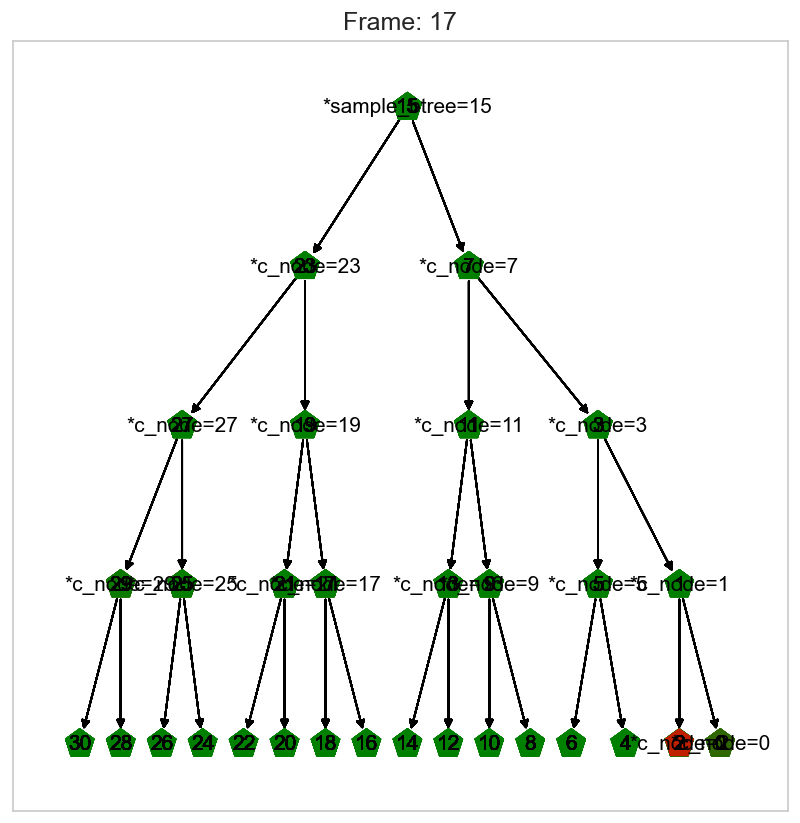

In [33]:
breadth_first_search(head_node=sample_btree, idx=4)

In [22]:
sample_btree._iter.as_gif('bfs_search.gif')
sample_btree._iter

## Binary Tree Search


In [34]:
def bt_search(head_node, idx):
    pos = graphviz_layout(head_node.graph, prog='dot')
    i = head_node.get_iter(max_value=32, pos=pos)
    c_node = head_node
    while True:
        i+=1
        if c_node.value==idx:
            
            return c_node
        
        c_children = c_node.children
        if len(c_children)==0:
            return None
        elif idx>c_node.value:
            c_node = c_children[-1]
        else:
            c_node = c_children[0]

None GraphNode (15): 2
GraphNode (15): 2 GraphNode (23): 2
GraphNode (23): 2 GraphNode (27): 2
GraphNode (27): 2 GraphNode (29): 2
GraphNode (29): 2 GraphNode (30): 0
GraphNode (29): 2 GraphNode (28): 0
GraphNode (27): 2 GraphNode (25): 2
GraphNode (25): 2 GraphNode (26): 0
GraphNode (25): 2 GraphNode (24): 0
GraphNode (23): 2 GraphNode (19): 2
GraphNode (19): 2 GraphNode (21): 2
GraphNode (21): 2 GraphNode (22): 0
GraphNode (21): 2 GraphNode (20): 0
GraphNode (19): 2 GraphNode (17): 2
GraphNode (17): 2 GraphNode (18): 0
GraphNode (17): 2 GraphNode (16): 0
GraphNode (15): 2 GraphNode (7): 2
GraphNode (7): 2 GraphNode (11): 2
GraphNode (11): 2 GraphNode (13): 2
GraphNode (13): 2 GraphNode (14): 0
GraphNode (13): 2 GraphNode (12): 0
GraphNode (11): 2 GraphNode (9): 2
GraphNode (9): 2 GraphNode (10): 0
GraphNode (9): 2 GraphNode (8): 0
GraphNode (7): 2 GraphNode (3): 2
GraphNode (3): 2 GraphNode (5): 2
GraphNode (5): 2 GraphNode (6): 0
GraphNode (5): 2 GraphNode (4): 0
GraphNode (3): 2 Gr

GraphNode (4): 0

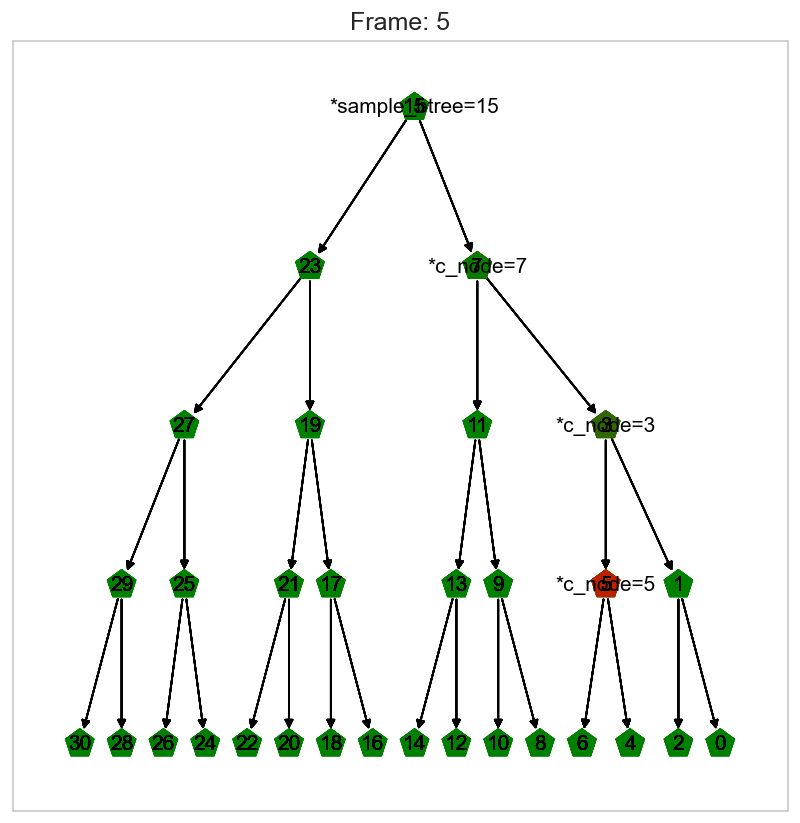

In [35]:
bt_search(head_node=sample_btree, idx=4)

In [25]:
sample_btree._iter.as_gif('bt_search.gif')
sample_btree._iter

# Cycle Detection
Kita dapat memeriksa adanya siklus dengan membuat dua penunjuk dan membiarkan mereka bergerak dengan kecepatan yang berbeda sampai mereka bertemu.

In [36]:
class LinkedList(GraphNode):
    def add_next(self, name):
        n_node = self.add_child(name)
        n_node.__class__ = LinkedList
        return n_node
    
    @property
    def next(self):
        children = self.children
        if len(children)>0:
            return children[0]
        else:
            return None

None GraphNode (head): 1
GraphNode (head): 1 GraphNode (head_next): 1
GraphNode (head_next): 1 GraphNode (node-0): 1
GraphNode (node-0): 1 GraphNode (node-1): 1
GraphNode (node-1): 1 GraphNode (node-2): 1
GraphNode (node-2): 1 GraphNode (node-3): 1
GraphNode (node-3): 1 GraphNode (node-4): 1
GraphNode (node-4): 1 GraphNode (node-5): 1
GraphNode (node-5): 1 GraphNode (node-6): 1
GraphNode (node-6): 1 GraphNode (node-7): 1
GraphNode (node-7): 1 GraphNode (node-8): 1
GraphNode (node-8): 1 GraphNode (node-9): 1
GraphNode (node-9): 1 GraphNode (head_next): 1


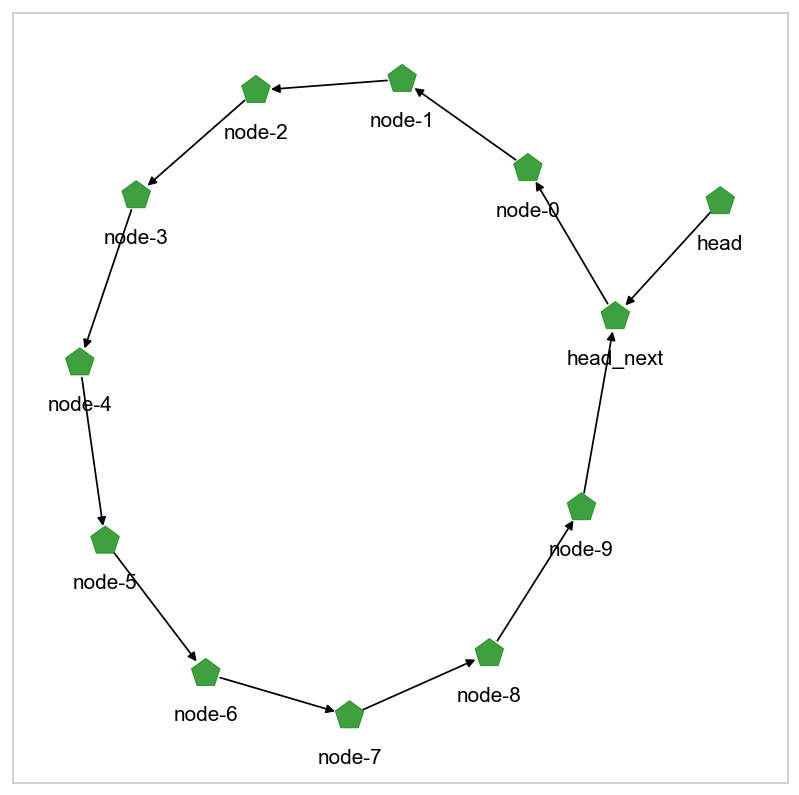

In [37]:
head = LinkedList('head')
head2 = head.add_next('head_next')
head.reset()
c_node = head2
for i in range(10):
    c_node = c_node.add_next('node-{}'.format(i))
c_node.add_next(head2)
head.draw();

In [38]:
def check_for_loop(list_head):
    i = list_head.get_iter()
    t1 = list_head
    t2 = list_head.next
    while(t1!=t2):
        if t1 is None: return False
        if t2 is None: return False
        t1 = t1.next
        t2 = t2.next
        if t2 is None: return False
        t2 = t2.next
        i+=1
    return True # they do match / is a loop

None GraphNode (head): 1
GraphNode (head): 1 GraphNode (head_next): 1
GraphNode (head_next): 1 GraphNode (node-0): 1
GraphNode (node-0): 1 GraphNode (node-1): 1
GraphNode (node-1): 1 GraphNode (node-2): 1
GraphNode (node-2): 1 GraphNode (node-3): 1
GraphNode (node-3): 1 GraphNode (node-4): 1
GraphNode (node-4): 1 GraphNode (node-5): 1
GraphNode (node-5): 1 GraphNode (node-6): 1
GraphNode (node-6): 1 GraphNode (node-7): 1
GraphNode (node-7): 1 GraphNode (node-8): 1
GraphNode (node-8): 1 GraphNode (node-9): 1
GraphNode (node-9): 1 GraphNode (head_next): 1
Read children from head
Read children from head
Read children from head2
Read children from t2
Read children from head2
Read children from t2
Read children from t2
Read children from t1
Read children from t2
Read children from t2
Read children from t1
Read children from t2
Read children from t2
Read children from t1
Read children from t2
Read children from t2
Read children from t1
Read children from c_node
Read children from head2
Read 

True

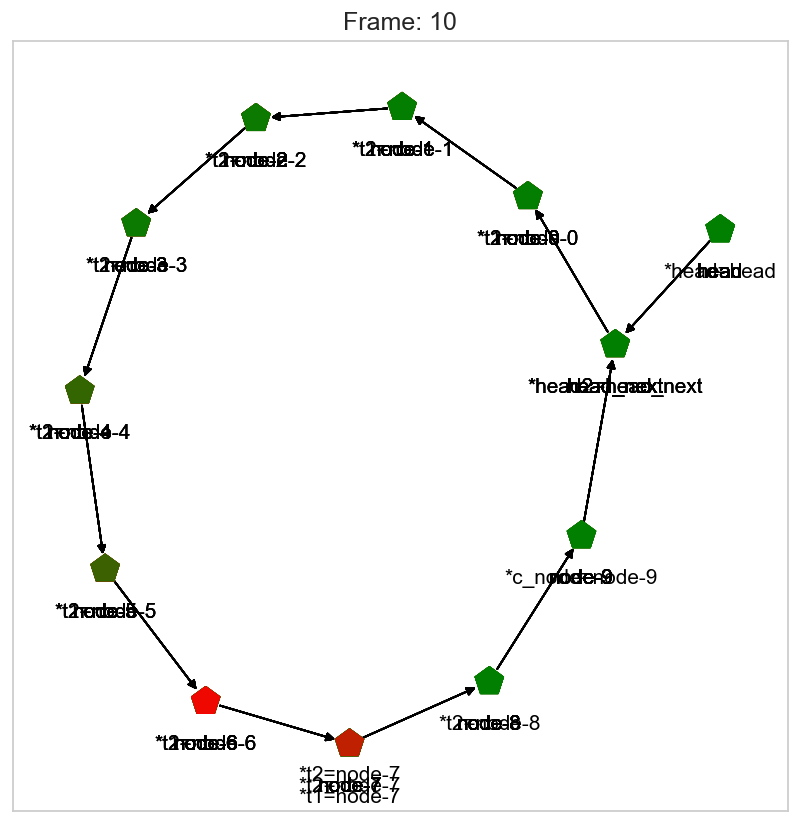

In [39]:
check_for_loop(head)

In [30]:
head._iter.as_gif('loop_check.gif')
head._iter

# Find Eventual Safe States
Sekarang, katakanlah simpul awal kita adalah aman akhirnya jika dan hanya jika kita pasti akhirnya berjalan ke simpul terminal. Lebih spesifik, ada bilangan alami K sehingga untuk setiap pilihan kemana harus berjalan, kita harus berhenti di simpul terminal dalam kurang dari K langkah.

Simpul mana yang aman akhirnya? Kembalikan mereka sebagai array dalam urutan yang diurutkan.

Graf berarah memiliki N simpul dengan label 0, 1, ..., N-1, di mana N adalah panjang graf. Graf disajikan dalam bentuk berikut: graf[i] adalah daftar label j sedemikian sehingga (i, j) adalah sisi berarah dari graf tersebut.
```
Example:
Input: graph = [[1,2],[2,3],[5],[0],[5],[],[]]
Output: [2,4,5,6]
```

In [40]:
def graph_list_to_node(in_list):
    g_dict = {idx: GraphNode(f'Node:{idx}') 
              for idx, links in enumerate(in_list)}
    for idx, links in enumerate(in_list):
        for k in links:
            g_dict[idx].add_child(g_dict[k])
    head = g_dict.pop(0)
    head.add_siblings(list(g_dict.values()))
    head.reset()
    return head

None GraphNode (Node:6): 0
None GraphNode (Node:5): 0
None GraphNode (Node:4): 1
GraphNode (Node:4): 1 GraphNode (Node:5): 0
None GraphNode (Node:3): 1
GraphNode (Node:3): 1 GraphNode (Node:0): 2
GraphNode (Node:0): 2 GraphNode (Node:2): 1
GraphNode (Node:2): 1 GraphNode (Node:5): 0
GraphNode (Node:0): 2 GraphNode (Node:1): 2
GraphNode (Node:1): 2 GraphNode (Node:3): 1
GraphNode (Node:1): 2 GraphNode (Node:2): 1
None GraphNode (Node:2): 1
GraphNode (Node:2): 1 GraphNode (Node:5): 0
None GraphNode (Node:1): 2
GraphNode (Node:1): 2 GraphNode (Node:3): 1
GraphNode (Node:1): 2 GraphNode (Node:2): 1
None GraphNode (Node:0): 2
GraphNode (Node:0): 2 GraphNode (Node:2): 1
GraphNode (Node:0): 2 GraphNode (Node:1): 2


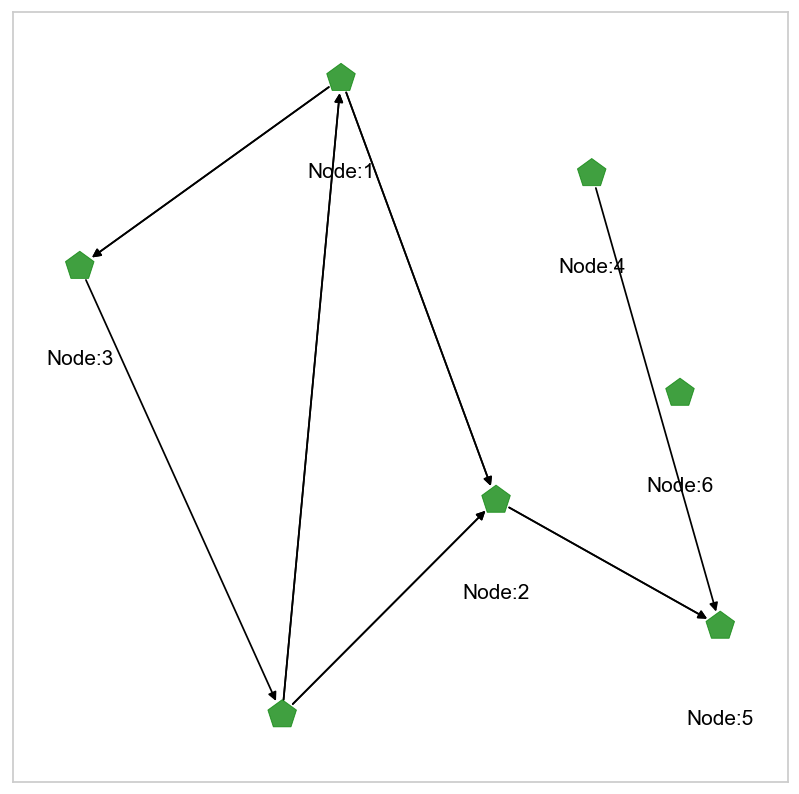

In [41]:
g_list = [[1,2],[2,3],[5],[0],[5],[],[]]
head = graph_list_to_node(g_list)
head.draw();

In [42]:
def find_safe_state(in_nodes):
    i = in_nodes[0].get_iter(max_value=100)
    safe_nodes = set()
    
    while len(in_nodes)>0:
        nodes_to_check = [in_nodes.pop()]
        visited_nodes = set()
        is_safe = True
        while len(nodes_to_check)>0:
            c_node = nodes_to_check.pop()
            visited_nodes.add(c_node)
            for i_node in c_node.children:
                i_node.value
                if i_node in visited_nodes:
                    nodes_to_check = []
                    is_safe = False
                elif i_node in safe_nodes:
                    pass
                elif len(i_node.children)<1:
                    safe_nodes.add(i_node)
                else:
                    nodes_to_check.append(i_node)
                i+=1
        if is_safe:
            for i_node in visited_nodes:
                safe_nodes.add(i_node)
    return safe_nodes

None GraphNode (Node:6): 0
None GraphNode (Node:5): 0
None GraphNode (Node:4): 1
GraphNode (Node:4): 1 GraphNode (Node:5): 0
None GraphNode (Node:3): 1
GraphNode (Node:3): 1 GraphNode (Node:0): 2
GraphNode (Node:0): 2 GraphNode (Node:2): 1
GraphNode (Node:2): 1 GraphNode (Node:5): 0
GraphNode (Node:0): 2 GraphNode (Node:1): 2
GraphNode (Node:1): 2 GraphNode (Node:3): 1
GraphNode (Node:1): 2 GraphNode (Node:2): 1
None GraphNode (Node:2): 1
GraphNode (Node:2): 1 GraphNode (Node:5): 0
None GraphNode (Node:1): 2
GraphNode (Node:1): 2 GraphNode (Node:3): 1
GraphNode (Node:1): 2 GraphNode (Node:2): 1
None GraphNode (Node:0): 2
GraphNode (Node:0): 2 GraphNode (Node:2): 1
GraphNode (Node:0): 2 GraphNode (Node:1): 2
Read children from c_node
Read children from c_node
Read children from c_node
Read value from i_node
Read children from c_node
Read value from head
Read children from head
Read children from head
Read value from i_node
Read children from i_node
Read value from i_node
Read children f

{GraphNode (Node:2): 1,
 GraphNode (Node:4): 1,
 GraphNode (Node:5): 0,
 GraphNode (Node:6): 0}

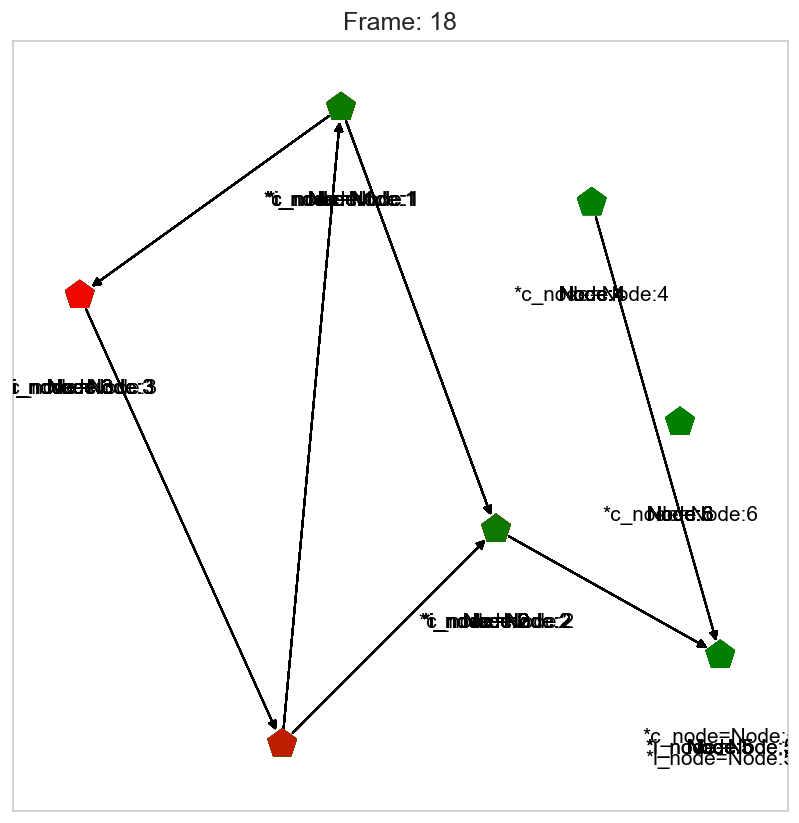

In [43]:
find_safe_state([head]+head._siblings)

In [35]:
head._iter.as_gif('eventual_safe.gif')
head._iter